# Aula 12

Nas aulas passadas começamos a trabalhar com o dataset do Titanic, fizemos a etapa de processamento e começamos a estudar as estatísticas descritivas do conjunto de dados.

In [1]:
import pandas as pd
import requests
from io import StringIO
import re

# Criação do dataFrame dos alunos
# ID do arquivo no Google Drive
file_id = '1S5Nl793vcL5ZPTGjzKaIEbwbLaDplvIP'

# URL modificada para forçar o download do arquivo
url = f"https://drive.google.com/uc?id={file_id}"

# Tentando obter o arquivo com requests
try:
    response = requests.get(url)
    response.raise_for_status()  # Lança um erro para respostas não-sucedidas
    # Usando StringIO para converter o texto em um arquivo em memória e, então, lendo com o Pandas
    csv_raw = StringIO(response.text)
    data = pd.read_csv(csv_raw)
except requests.RequestException as e:
    print(f"Erro ao acessar o arquivo: {e}")


#Transformando o PassengerId no índice
data = data.set_index("PassengerId")

#Criando uma função que encontra os pronomes de tratamentos dos passageiros
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

#Aplicando a função na coluna de nomes, isto é, criando uma coluna só com os pronomes de tratamentos
data['Title'] = data['Name'].apply(extract_title)

#Substituindo os valores ausentes das idades pela mediana agrupada por sexo e classe de passageiro
data['Age'] = data.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

#Substituindo os valores ausentes do porto de embarque pelo valor que mais apareceu
data['Embarked'] = data['Embarked'].fillna('S')

#Substituindo os valores ausentes da cabine com base na Classe e no mapa do navio
for num in [1, 2, 3]:
    if num == 1:
        data.loc[data['Pclass'] == 1, 'Cabin'] = data.loc[data['Pclass'] == 1, 'Cabin'].fillna('ABC')
    elif num == 2:
        data.loc[data['Pclass'] == 2, 'Cabin'] = data.loc[data['Pclass'] == 2, 'Cabin'].fillna('DE')
    elif num == 3:
        data.loc[data['Pclass'] == 3, 'Cabin'] = data.loc[data['Pclass'] == 3, 'Cabin'].fillna('FG')


In [2]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,FG,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,FG,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,FG,S,Mr



| Nome da Variável | Descrição                               |
|------------------|-----------------------------------------|
| Survived         | Sobreviveu (1) ou morreu (0)            |
| Pclass           | Classe do passageiro (1 = Upper Class, 2 = Middle Class, 3 = Lower Class) |
| Name             | Nome do passageiro                      |
| Sex              | Sexo do passageiro                      |
| Age              | Idade do passageiro                     |
| SibSp            | Número de irmãos/cônjuges a bordo       |
| Parch            | Número de pais/filhos a bordo           |
| Ticket           | Número do bilhete                       |
| Fare             | Tarifa                                  |
| Cabin            | Cabine                                  |
| Embarked         | Porto de embarque C = Cherbourg, Q = Queenstown, S = Southampton|

Para transformar as colunas categóricas 'Sex', 'Cabin', e 'Title' em números usando LabelEncoder do pacote sklearn, você pode seguir os passos abaixo.

In [13]:
from sklearn.preprocessing import LabelEncoder

# Inicializando o LabelEncoder
label_encoder = LabelEncoder()

df_encoded = data.copy()

# Colunas a serem transformadas
columns_to_encode = ['Sex', 'Cabin', 'Title', 'Embarked']

# Aplicando LabelEncoder às colunas categóricas
for column in columns_to_encode:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])
    
#Retirando as colunas Nome e Ticket
df_encoded = df_encoded.drop(['Name','Ticket'], axis=1)

# Mostrando o DataFrame transformado
df_encoded.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Probability,Classification
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2,12,0.091341,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,82,0,13,0.970505,1
3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2,9,0.465596,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,56,2,13,0.968323,1
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2,12,0.116017,0


### Criando um Classificador

O Random Forest Classifier é um método de aprendizado de máquina baseado em um conjunto de árvores de decisão. Este algoritmo é amplamente utilizado devido à sua simplicidade e eficácia, sendo uma das escolhas mais populares para tarefas de classificação e regressão.

#### Princípios Básicos

**Aprendizado por Conjunto (Ensemble Learning):** O Random Forest é um exemplo clássico de aprendizado por conjunto. Ele combina várias árvores de decisão para produzir uma predição mais robusta e precisa. A ideia principal é que, ao combinar vários modelos fracos (árvores de decisão), pode-se formar um modelo forte.

**Árvores de Decisão:** Cada árvore de decisão no conjunto é construída utilizando uma amostra diferente dos dados de treinamento. Essas árvores são treinadas para fazer predições com base em diferentes subconjuntos dos dados de entrada e características.

Durante o treinamento, várias amostras de bootstrap são geradas a partir dos dados de treinamento originais. Cada amostra é criada selecionando aleatoriamente, com reposição, os exemplos do conjunto de dados. Isso significa que alguns exemplos podem aparecer várias vezes em uma amostra, enquanto outros podem não aparecer.

Para cada amostra de bootstrap, uma árvore de decisão é construída. No Random Forest, há um passo adicional de aleatoriedade: em cada nó da árvore, uma seleção aleatória de características é considerada para a divisão, em vez de usar todas as características. Isso aumenta a diversidade entre as árvores e ajuda a reduzir a correlação entre elas.

Para fazer uma predição, o Random Forest Classifier passa o exemplo a ser classificado por todas as árvores no conjunto. Cada árvore faz sua própria predição, e a predição final é determinada pela maioria das árvores (votação majoritária) no caso de classificação. No caso de regressão, a média das predições de todas as árvores é usada.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(df_encoded.drop(['Survived'],axis=1),
                                                     df_encoded['Survived'],
                                                     test_size = 0.3,
                                                     random_state = 1234)

[{'treino':x_train.shape},{'teste':x_test.shape}]

[{'treino': (623, 9)}, {'teste': (268, 9)}]

In [9]:
rf = RandomForestClassifier(n_estimators=1000,
                            criterion='gini',
                            max_depth = 5)

rf.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000)

In [11]:
prob = rf.predict_proba(df_encoded.drop('Survived',axis =1))[:,1]
cla = rf.predict(df_encoded.drop('Survived',axis = 1))

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = rf.predict(x_test)
y_prob = rf.predict_proba(x_test)[:, 1]


### Matriz de Confusão

A matriz de confusão mostra os verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos:

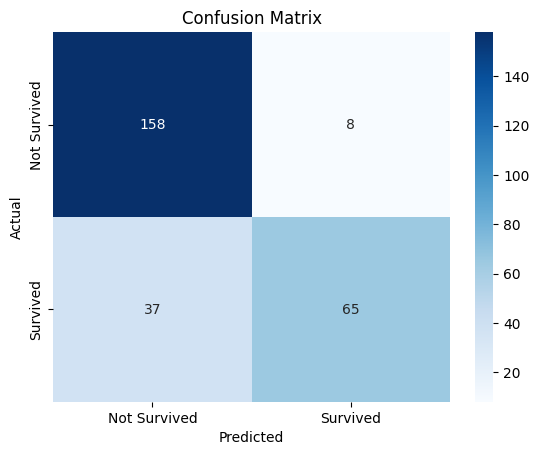

In [15]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Acurácia
A acurácia é a proporção de previsões corretas sobre o total de previsões:

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.83


### Precisão, Revocação e F1-Score
A precisão (precision) é a proporção de verdadeiros positivos sobre o total de positivos preditos. A revocação (recall) é a proporção de verdadeiros positivos sobre o total de positivos reais. A pontuação F1 é a média harmônica da precisão e revocação:

In [17]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precisão: {precision:.2f}')
print(f'Revocação: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Precisão: 0.89
Revocação: 0.64
F1-Score: 0.74


### AUC-ROC
A AUC-ROC mede a capacidade do modelo de distinguir entre classes. Uma AUC de 1.0 indica um classificador perfeito, enquanto uma AUC de 0.5 indica um classificador aleatório:

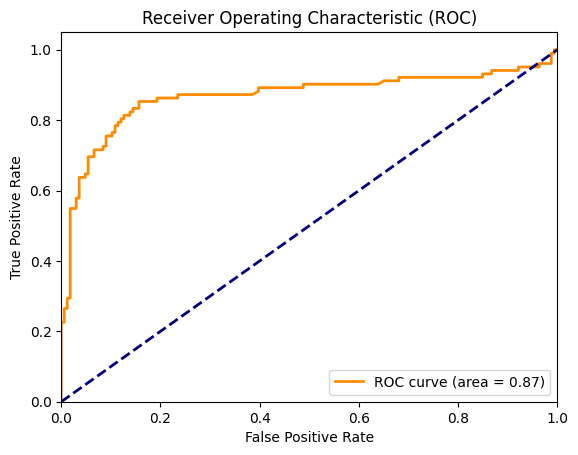

AUC-ROC: 0.87


In [18]:
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
print(f'AUC-ROC: {roc_auc:.2f}')


In [19]:
data['Probability'] = prob
data['Classification'] = cla
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Probability,Classification
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,FG,S,Mr,0.091341,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0.970505,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,FG,S,Miss,0.465596,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0.968323,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,FG,S,Mr,0.116017,0


### Um classificador

In [38]:
def prever_sobrevivencia(model, attributes, df_template):
    """
    Função para prever a probabilidade de sobrevivência com base em atributos fornecidos.
    
    Parâmetros:
    - model: O modelo treinado (Random Forest).
    - attributes: Um dicionário contendo os atributos necessários para a predição.
    - df_template: DataFrame usado como template para manter a ordem e colunas corretas.
    
    Retorna:
    - probabilidade: A probabilidade de sobrevivência.
    - classificacao: 1 se a pessoa provavelmente sobreviveu, 0 caso contrário.
    """
    # Adicionar placeholders para 'Cabin' e 'Title' nos atributos fornecidos
    attributes['Cabin'] = 0
    attributes['Title'] = 0
    
    # Crie um DataFrame com os atributos fornecidos
    df = pd.DataFrame([attributes])
    
    # Colunas necessárias para a predição, baseadas no df_template
    columns_to_use = df_template.drop(['Survived', 'Probability', 'Classification', 'Name', 'Ticket'], axis=1, errors='ignore').columns
    
    # Reindexe para garantir que todas as colunas estejam presentes
    df = df.reindex(columns=columns_to_use, fill_value=0)
    
    # Faça a previsão
    probabilidade = model.predict_proba(df)[:, 1][0]
    classificacao = model.predict(df)[0]
    
    return probabilidade, classificacao

# Exemplo de uso da função
atributos_exemplo = {
    'Pclass': 2,
    'Sex': 0, 
    'Age': 40,
    'SibSp': 1,
    'Parch': 0,
    'Fare': 50.25,
    'Embarked': 2 
}

probabilidade, classificacao = prever_sobrevivencia(rf, atributos_exemplo, df_encoded)
print(f'Probabilidade de Sobrevivência: {probabilidade:.2f}')
print(f'Classificação: {"Sobreviveu" if classificacao == 1 else "Não Sobreviveu"}')


Probabilidade de Sobrevivência: 0.81
Classificação: Sobreviveu
